# Deep Learning course - LAB 5

## Pruning in Artificial Neural Networks

### Recap from previous Labs

* Essentially, we now have a bag of _tricks_ to utilize in order to ensure our Multilayer Perceptrons (MLPs) train well while preserving a good generalization
* We know how to construct a simple MLP with a custom number of layers and neurons
* We know how to train the MLP using popular variants of Stochastic Gradient Descent (SGD) such as SGD with momentum and Adam
* We learned some tricks to enforce a better generalization capability of our MLP, namely Weight Decay and Dropout
* We saw how to use proper learning rate schedules for better convergence of our network

### Agenda for today

* Today, we are going more into the detail of Deep Learning (DL) for a more technical lab session devoted to a more "experimental" branch: **network pruning**
* We will see how to implement a specific pruning algorithm, Magnitude Pruning (MP), in an MLP

## What is pruning?

Pruning is referred to the specific act of **removing parameters from a Machine learning model**.

The term originated from tree-based models that, when grown too deep, present pronounced tendencies towards overfitting, so their branches need to be cut (*pruned*) with proper criteria in order to ensure a better generalization.

The main difference between pruning tree-based models and Artificial Neural Networks (ANNs) lies in the fact that, while in tree-based models we operate pruning on _leaf parameters_, in ANNs we usually prune without regard for the position of the parameter, which is a connection (_synapse_) between neurons.

![](https://www.cs.cmu.edu/~bhiksha/courses/10-601/decisiontrees/DTprune.png)

*In decision trees, models are pruned _downside up_ starting from the leaves. Picture from [Carnegie Mellon University](https://www.cs.cmu.edu/~bhiksha/courses/10-601/decisiontrees/).*

![](https://upload.wikimedia.org/wikipedia/commons/2/23/Before_after_pruning.png)

*In ANNs, generically, pruning is operated regardless of the position of the neuron/connection within the network. Picture from [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Before_after_pruning.png).*



## Why pruning?

Pruning (also called _Weight Sparsification_) is a collection of techniques falling within the category of **Network Miniaturization/Compression**, a bulk of practices aimed at reducing the size, or memory impact, or energetic impact, of a well-performing ANN, while still allowing the _reduced_ model to perform on-par with the original network.

Some other examples of Network Compression include, but not limited to:
* Knowledge Distillation
* Weight Quantization
* Weight Sharing

## How to prune?

Pruning in ANNs is a theme that has been around since the early works of Yann LeCun [2](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.32.7223&rep=rep1&type=pdf) in the late 80s. A huge number of techniques has been proposed since then [3](https://arxiv.org/abs/2102.00554).

The findings in these early papers are essentialy different from those in the most recent ones (i.e., from 2015 on) mainly because the networks back then were not deep: large ANNs tend instead to react differently to pruning.

Regarding how to prune, we can distinguish between two main categories: **Structured Pruning** and **Unstructured Pruning**.

### Structured pruning

To render this classification as neat as possible, structured pruning acts on multiple synapses logically connected in some way. In the case of MLPs, we may think of the act of _removing a neuron_ from a given layer as a structured pruning technique, as we **remove all the connections incoming towards that neuron**.

![](img/struct_prune.png)

In the image above, we prune the first neuron of the second layer. This equates to removing all of its incoming connections. The effect of this on the parameters of the ANN is that now we have a so called *regular sparsity*: the original parameters $\Theta\in\mathbb{R}^{4\times 3}$ are now $\tilde\theta\in\mathbb{R}^{4\times 2}$.

### Unstructured pruning

In this case, instead, we utilize a pruning technique which has no regard for the geometry or the structure of the layers themselves.

![](img/unstr_prune.png)

In the image above, we removed four connections. This leads to an *irregular* form of sparsity in the parameters, which can't be taken advantage of directly, as happened instead in the structured case.
There exist algorithms for sparse linear algebra which can be used in these cases (implemented for example in CuSPARSE) or some specific processor architectures are designed to take advantage of sparsity in matrices (e.g., NVIDIA Tesla A100 GPU).

In this lab we will deal with unstructured sparsity, but an extension to structured sparsity can be easily derived.

## (Least) Magnitude pruning

MP is one of the most straight-forward pruning techniques. Essentially, we remove a fixed fraction of parameters exhibiting a low absolute value.

To get more technical:

* Let us call $\Theta$ the *structure* holding all of the parameters in the network.

* Let us also introduce $p\in(0,1)$, the **pruning rate**. This is the fixed fraction of parameters with small magnitude that we will prune.

1. We obtain $\vec\Theta = \text{vec}\vert\Theta\vert$, the **empirical distribution of the parameters in magnitude**

2. We sort $\vec\Theta$, obtaining $\vec\Theta_\text{sort}$

3. We obtain $\theta_p$ the $p$-th percentile of $\vec\Theta_\text{sort}$, which will act as a threshold for determining which parameters are going to be pruned.

4. For each of the parameter $\theta$ in the original $\Theta$, we operate the pruning: $\tilde\theta = \theta \cdot \mathbb{1}[\vert\theta\vert\geq\theta_p]$ (NB: $\mathbb{1}$ is the *indicator function*, which evaluates to 1 if the condition inside the brackets is verified, to 0 otherwise).

5. We replace $\Theta$ with $\tilde\Theta$, the structure composed of the various $\tilde\theta$s.

#### Masking

The same procedure described above can be obtained with masking. Essentially, instead of directly building $\tilde\Theta$ as element-wise application of $\tilde\theta = \theta \cdot \mathbb{1}[\vert\theta\vert\geq\theta_p]$, we rather do this:

4. $m = \mathbb{1}[\vert\theta\vert\geq\theta_p]$. $m$ is a boolean telling us whether the corresponding parameters needs to be pruned or not. We have as many $m$s as there are $\theta$s.

5. We compose the $m$s in a structure $M$, identical in shape to $\Theta$.

6. Now, $\tilde\Theta = M\odot \Theta$, where $\odot$ is the Hadamard product.

This is the way in which pruning (analogously to Dropout) will be operated by us on PyTorch.

#### Global vs Local

The current version of MP operates on a global logic: we pool all of the parameters and prune w.r.t. one single threshold $\theta_p$.
If we wanted to complicate things just a little bit, we could instead pool parameters in different buckets and prune buckets separately (local approach):

0. Divide the parameters in buckets $\Theta_b, b\in\{1,...,B\},~~\cup_b\Theta_b=\Theta,~\Theta_b\cap\Theta_{b^\prime} = \varnothing$.

All the following points 1.-6. are operated separately for each bucket, so we will have a thresold for each bucket, a mask for each bucket...

This strategy might be operated if we wanted to operate pruning separately for some specific layers. For example, [4](https://arxiv.org/abs/1803.03635) specifies that the reached better results when operating lower pruning rates on output layers. Nonetheless, this practice has fallen off, since in Deep ANNs, a global approach has been empirically proven more effective.

### Perchance, did we already meet magnitude pruning somewhere???

Indeed, L1-norm regularization is a form of *implicit pruning* operated during the training of the network. Although in theory it seems to work, in practice it doesn't work as well as MP, and some works (see [3](https://arxiv.org/abs/2102.00554)) have shown that L1-norm regularization does not work well with normalization layers, which play a fundamental role for faster convergence of SGD.

In [118]:
import torch
from scripts import mnist, train_utils, architectures, train

For the point 4., we'll be using `torch.where`. Let's see first what it is and how does it work:

In [5]:
x = torch.rand((5,10)) # random tensor
y = torch.where(x<.5)
print(type(y))
print(y)

<class 'tuple'>
(tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4]), tensor([6, 7, 8, 9, 3, 4, 5, 6, 0, 1, 2, 4, 7, 3, 6, 7, 9, 1, 7, 9]))


It returns a tuple of length `d`, where `d` is the number of dimensions of the tensor `x`.

But we can use it differently:

In [8]:
torch.where(x<.5, 1, 0)

tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 1]])

by specifying two following arguments, we actually create a tensor with the same structure as `x`, where the element of `x` abiding to the condition in `torch.where` take on the value reported as the second argument; those who do not, assume the third argument instead. I hope it is straightforward how this method will be integrated in the pruning fct.

In [10]:
# First we will create the function for obaining a mask from a single tensor of parameters
def binarize(tensor, threshold):
    return torch.where(..., ..., ...) # fill in the blanks & be wary of the MAGNITUDE

def magnitude_pruning(model, pruning_rate):
    # 1. vectorize distribution of abs(parameter)
    flat = ...
    # 2. sort this distribution
    flat = flat.sort()[0]
    # 3. obtain the threshold
    position = ...
    thresh = ...
    # 4. binarize the parameters & 5. compose these booleans into the mask
    mask = ...
    # 6. obtain the new structure of parameters
    for param, m in zip(parameters, mask):
        param.data *= m
    # 7. what do we need to return?
    return None

In [87]:
torch.where((x<.5)|(x>.8))

(tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3,
         3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]),
 tensor([0, 1, 4, 6, 7, 8, 9, 1, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 4, 5, 7, 9, 1, 2,
         3, 4, 6, 7, 8, 9, 1, 3, 4, 5, 7, 9]))

In [38]:
k = next(net.parameters())
kk = next(net.parameters())
w = torch.cat((k.flatten(),kk.flatten()))

In [88]:
def magnitude_pruning(model, p):
    flat = torch.cat([param.detach().cpu().flatten().abs() for param in model.parameters()])
    flat = flat.sort()[0]
    position = int(p * flat.shape[0])
    thresh = flat[position].item()
    mask = [torch.where(param.abs()>=thresh, 1, 0) for param in model.parameters()]
    for param, m in zip(model.parameters(), mask):
        param.data *= m
    return mask

Let us see our algorithm at work:

In [114]:
layers = [
    {"n_in": 784, "n_out": 16, "batchnorm": False},
    {"n_out": 32, "batchnorm": True},
    {"n_out": 64, "batchnorm": True},
    {"n_out": 10, "batchnorm": True}
]
net = architectures.MLPCustom(layers)
print(net)

MLPCustom(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=32, out_features=64, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=64, out_features=10, bias=True)
    (11): ReLU()
  )
)


In [90]:
mask = magnitude_pruning(net, .2)

Did it work? Let's analyze the mask

In [96]:
print("Number of ones in mask:", sum([m.sum().item() for m in mask]) / sum([m.numel() for m in mask]), "\n")
print(mask[0][0,:20], "\n", next(net.parameters())[0,:20])

Number of ones in mask: 0.8000079622588928 

tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) 
 tensor([-0.0169, -0.0196, -0.0118,  0.0160, -0.0095, -0.0098,  0.0144, -0.0000,
        -0.0000,  0.0000,  0.0068, -0.0124, -0.0240, -0.0187, -0.0135, -0.0140,
        -0.0167, -0.0137,  0.0092,  0.0329], grad_fn=<SliceBackward>)


#### **Q**: What is wrong with this implementation?

*Think about the type of layers we have in our MLP...*

In [ ]:
# correct here the mistake
def magnitude_pruning(model, pruning_rate):
    # 1. vectorize distribution of abs(parameter)
    flat = ...
    # 2. sort this distribution
    flat = flat.sort()[0]
    # 3. obtain the threshold
    position = ...
    thresh = ...
    # 4. binarize the parameters & 5. compose these booleans into the mask
    mask = ...
    # 6. obtain the new structure of parameters
    for param, m in zip(parameters, mask):
        param.data *= m
    # 7. what do we need to return?
    return None

## When to prune?

Usually, pruning is operated on a **fully trained model**.

Let us see what happens when we prune a trained model.

In [115]:
trainloader, testloader, _, _ = mnist.get_data()
loss_fn = torch.nn.CrossEntropyLoss()

In [126]:
# load pretrained model
state_dict = torch.load("models_push/mlp_custom_mnist/mlp_custom_mnist.pt")
net.load_state_dict(state_dict)
train.test_model(net, testloader, loss_fn=loss_fn)

TESTING - loss 7349.624454498291 - performance 0.9631333333333333


(7349.624454498291, 0.9631333333333333)

In [128]:
train.test_model(net, testloader, loss_fn=loss_fn)

TESTING - loss 8261.046932697296 - performance 0.9573333333333334


(8261.046932697296, 0.9573333333333334)

We see that there's a drop in performance. This is a characteristic of pruning. Rarely a simple application of pruning leaves the performance untouched or better. Due to that, we must procede with a re-training of the ANN.

## Retraining the network

The retraining can be carried out in different ways:

### Fine-tune (FT)

This means that, after pruning, we retrain for a few epochs without touching the optimizer (i.e., we do not employ a LR schedule but leave the hyperparameters untouched w.r.t. their final configuration).

### Learning Rate Rewind (LRR)

After pruning, we re-train for the same number of epochs of the original training, resetting the optimizer hyperparameters as well

### Weight Rewind (WR, a.k.a. _Lottery Ticket Hypothesis_)

After pruning, we **reset** the surviving weights to their original configuration, then we re-train as in LRR. The idea behind the Lottery Ticket Hypothesis (LTH) is that, within a randomly initialized ANN, there lies a subnetwork (i.e., a subset of the ANN connections) who is actually responsible for the good performance of the dense ANN. It's hence assumed that this subnetwork has _won the lotter of initialization_.

## Iterating the procedure

Actually, all three procedures can be iterated (Iterative Magnitude Pruning, IMP). So, if we prune 25% of the ANN for each step, we can reach high pruning rates (e.g. 10 iterations of IMP $\Rightarrow$ final sparsity of the ANN of about $0.75^{10}\approx 0.0563$).

Of course, IMP applied 10 times with a pruning rate of 0.25 yields far better result than a one-shot pruning + retraining with $p=0.95$.

## Who wins and who doesn't?

[5](https://arxiv.org/abs/2003.02389) does an excellent job in comparing these three paradigms, concluding that, as far as accuracy is involved, **LRR beats all of its competitors** on the long run. Despite that, a lot of recent publications still use a one-shot pruning followed by FT, this because LRR in the IMP setting can be very expensive in terms of time and energy. Moreover, we showed ([6](https://medvet.inginf.units.it/publications/2021-c-zmpa-speeding/)) that, at high pruning rates, we can "cut the corners" and re-train for less epochs while still getting good accuracy w.r.t. WR and LRR.

## What about Weight Rewind?

The LTH has sparked some debate in the ML community and has allowed for some interesting analysis, especially concerning the initial phase of training. In particular, the almost-defunct Uber AI has done some [additional research](https://eng.uber.com/deconstructing-lottery-tickets/) showing some interesting insights:
* Random Pruning (RP) shows no benefit even after retraining. That confirms that re-training alone is not responsible for the effectiveness of the pruned network: you also need an _intelligent_ pruning algorithm;
* Recalling the LTH, its application requires a parameters *reset* before retraining. As you can see from the image below, the sole application of the MP mask (_LT Mask_ in the picture) to a pruned and rewound network already increases the accuracy of the network by ~30%. This would seem to corroborate empirically the LTH.

![](https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/image3-2-696x497.png)

* Another heuristic is the so-called **supermask**, which keeps parameters which have mantained the sign during training and have a large final value. Parameters crossing the zero, despite large, are going to be pruned nonetheless. Of course, the supermask is more memory-intensive because we need to keep track of the evolution of the parameters in time.

![](https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/image2-1-420x420.png)

It's interesting to note how the supermask performs incredibly well after pruning and rewind (i.e., on untrained networks). The supermask is indicated as `large_final_same_sign`:

![](https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/image1-3-685x420.png)

*All images from [Uber AI](https://eng.uber.com/deconstructing-lottery-tickets/)*.

### Implementation of the retraining procedure

If we retrain the network as-is, we will soon notice that we did a big mistake, because we have in no way communicated to PyTorch that the MLP does **not** have to be retrained on the pruned parameters.

In order to enforce that, we must act on the training loop, namely `train_epoch`.

In [131]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, device, mask, params_type_to_prune):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad() 

        y_hat = model(X)

        loss = loss_fn(y_hat, y)

        loss.backward()

        ##### we must neutralize the gradient on the pruned params before the optimizer takes a step ####

        if mask is not None:
            for (name, param), m in zip(model.named_parameters(), mask):
                if any([l in name for l in layers_to_prune]):
                    param.grad *= m

        ######

        optimizer.step()

        acc = performance(y_hat, y)

        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])

0.056313514709472656

let us integrate it with our `train_model` routine:

In [ ]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, lr_scheduler=None, device=None, mask=None, params_type_to_prune=["weight", "bias"]):
    if checkpoint_loc is not None:
        os.makedirs(checkpoint_loc, exist_ok=True)

    if device is None:
        device = use_gpu_if_possible()
    
    model = model.to(device)
    model.train()

    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        print(f"Epoch {epoch+1} --- learning rate {optimizer.param_groups[0]['lr']:.5f}")

        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, mask, params_type_to_prune)

        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Performance: {performance_meter.avg}")

        if checkpoint_name is not None and checkpoint_loc is not None:
            checkpoint_dict = {
                "parameters": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch
            }
            torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))
        
        if lr_scheduler is not None:
            lr_scheduler.step()

    return loss_meter.sum, performance_meter.avg

Now, we can effectively retrain the pruned ANN by simply passing the `mask` to the training routine.

#### Homework

"Close the loop" for implementing IMP. Right now, the `magnitude_pruning` routine is thought for one-shot pruning. If you try pruning one more time, you'll notice that it will not work as there's no way to communicate to the future calls of `magnitude_pruning` to ignore the parameters which have already been pruned. Find a way to enhance the routine s.t. it can effectively prune networks in a sequential fashion (i.e., if we passed an MLP already pruned of 20% of its parameters, we want to prune *another* 20% of parameters).

Hint:

![](img/force.jpg)

In [134]:
import numpy as np

In [137]:
x = np.array([[1,2,3,4],[1,2,3,5]])
y = np.random.chisquare(x)
print(y)

[[0.94450544 0.32553718 2.90253417 4.05758069]
 [1.8441957  0.18773161 2.39469929 2.06660618]]


In [208]:
class SqrtActivation(torch.nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.n_in = n_in
        w = torch.rand((n_in, ))
        self.w = torch.nn.Parameter(w)
        torch.nn.init.uniform_(self.w, 2.0, 8.0)
    
    def forward(self, x):
        s = x.sign()
        return s * (x.abs() ** (1/self.w))
    
    def backward(self, grad_output):
        

In [251]:
class VariableSqrt(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_, weight):
        sign = input_.sign()
        output = input_.abs() ** (1/weight)
        return sign * output
    
    @staticmethod
    def backward(ctx, grad_output):
        input_, weight = ctx.saved_tensors
        weight_1 = 1 / weight
        sign_input = input_.sign()

        grad_input = grad_output * weight_1 * (input_.abs() ** (weight_1 - 1))
        grad_input *= sign_input
        grad_weight = (input_.abs() ** weight_1) * input_.abs().log() * (-1 * weight_1 * weight_1)
        
        return grad_input, grad_weight



In [252]:
sq = VariableSqrt.apply

In [260]:
x = torch.rand((10,))
x = x.require_grad()
w = torch.Tensor([1,1,2,2,3,3,4,4,5,5], require_grad=True)
y = sq(x, w)
z = y.sum()

AttributeError: 'Tensor' object has no attribute 'require_grad'

In [257]:
z.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [205]:
mynet = FancyLayer(10)
x = torch.rand((10,))
h, s = mynet(x)
z = h.sum()

In [206]:
z.backward()

In [246]:
xxx = np.linspace(0, 3, num=200)
yyy = []
yyy.append(xxx ** (1/2))
yyy.append(xxx ** (1/2.5))
yyy.append(xxx ** (1/3))
yyy.append(xxx ** (1/4))
yyy.append(xxx ** (1/8))
xxxx = np.hstack((-np.flip(xxx), xxx))
yyyy = [np.hstack((np.flip(y_), y_)) for y_ in yyy]

In [247]:
h = np.array([1,2,3])


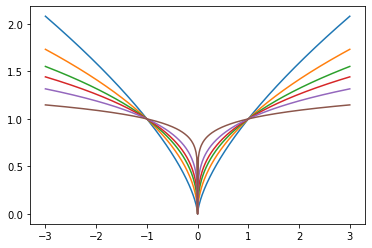

In [248]:
from matplotlib import pyplot as plt
plt.plot(xxxx,yyyy[0])
plt.plot(xxxx,yyyy[1])
plt.plot(xxxx,yyyy[2])
plt.plot(xxxx,yyyy[3])
plt.plot(xxxx,yyyy[4])
plt.plot(xxxx,yyyy[5])

In [222]:
2**0.5


1.4142135623730951

### References

[1](https://arxiv.org/abs/2006.03669) O'Neill, James. "An Overview of Neural Network Compression."

[2](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.32.7223&rep=rep1&type=pdf) Yann LeCun, John Denker, Sara Solla. "Optimal Brain Damage."

[3](https://arxiv.org/abs/2102.00554) Hoefler, Torsten, et al. "Sparsity in Deep Learning: Pruning and growth for efficient inference and training in neural networks."

[4](https://arxiv.org/abs/1803.03635) Frankle, Jonathan, and Michael Carbin. "The lottery ticket hypothesis: Finding sparse, trainable neural networks."

[5](https://arxiv.org/abs/2003.02389) Renda, Alex, Jonathan Frankle, and Michael Carbin. "Comparing rewinding and fine-tuning in neural network pruning."

[6](https://medvet.inginf.units.it/publications/2021-c-zmpa-speeding/) Zullich, Marco, Eric Medvet, Felice Andrea Pellegrino, and Ansuini, Alessio. "Speeding-up pruning for Artificial Neural Networks: Introducing Accelerated Iterative Magnitude Pruning."